In [1]:
from planet4.clustering import ClusteringManager
from planet4 import p4io as io
from IPython.display import display
from ipywidgets import FloatText
from pathlib import Path

In [2]:
db = io.get_current_season23_dbase()
dbname = db.dbname

In [3]:
def process_image_name(img_name):
    from pathlib import Path
    from planet4.clustering import ClusteringManager
    output_dir = Path('/Users/klay6683/data/planet4/inca_seasons2and3_v2')
    output_dir.mkdir(exist_ok=True)
    cm = ClusteringManager(dbname, scope='hirise',
                           output_dir=output_dir,
                           output_format='both')
    cm.cluster_image_name(img_name)
    return img_name

In [4]:
obsids = !cat /Users/klay6683/Dropbox/data/planet4/season2_3_image_names.txt

In [7]:
process_image_name(obsids[0])

'ESP_013113_0985'

In [5]:
from ipyparallel import Client
c = Client()

In [6]:
lbview = c.load_balanced_view()

In [7]:
dview = c.direct_view()

In [8]:
dview.push({'dbname': str(db.dbname)})

<AsyncResult: finished>

In [9]:
results = lbview.map_async(process_image_name, obsids)

In [10]:
from iuvs.multitools import nb_progress_display

In [ ]:
nb_progress_display(results, obsids)

In [10]:
cm.confusion_data

[autoreload of importlib._bootstrap failed: Traceback (most recent call last):
  File "/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _collections_abc failed: Traceback (most recent call last):
  File "/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: module collections.abc not in sys.modules
]
[autoreload of importlib failed: Traceback (most recent call last):
  File "/Users/klay6683/miniconda3/envs/py35/lib/python3.5/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'importlib' has no attribute 'reload'
]
[autoreload of importlib._bootstrap_external failed: Traceback (

error: internal: unsupported operand type ANY

In [10]:
cm.save_confusion_data('/Users/klay6683/Dropbox/data/planet4/season2_3_confusion_data.csv')

error: internal: unsupported operand type ANY

In [10]:
cm.report()

error: internal: unsupported operand type ANY

In [37]:
def calculate_tile_offset(df):
    df = df.assign(tile_xoff=lambda row: (740 * (row.x_tile - 1)).round(),
                   tile_yoff=lambda row: (548 * (row.y_tile - 1)).round())
    return df


In [89]:
p4id = markings.ImageID('APF00002q7')

In [43]:
p4id.data = calculate_tile_offset(p4id.data)

In [47]:
import gdal

In [48]:
cubfname = '/Users/klay6683/data/hirise/ESP_011544_0985_RGB.NOMAP.cub'

In [49]:
ds = gdal.Open(cubfname)

In [57]:
xoff, yoff = p4id.data.iloc[0].tile_xoff, p4id.data.iloc[0].tile_yoff

In [67]:
imgdata = ds.ReadAsArray(int(xoff), int(yoff), 840, 648)

In [74]:
%matplotlib nbagg

In [41]:
import seaborn as sns
sns.set_context('talk')

/Users/klay6683/miniconda3/lib/python3.4/site-packages/matplotlib-1.5.dev1-py3.4-macosx-10.5-x86_64.egg/matplotlib/__init__.py:867: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


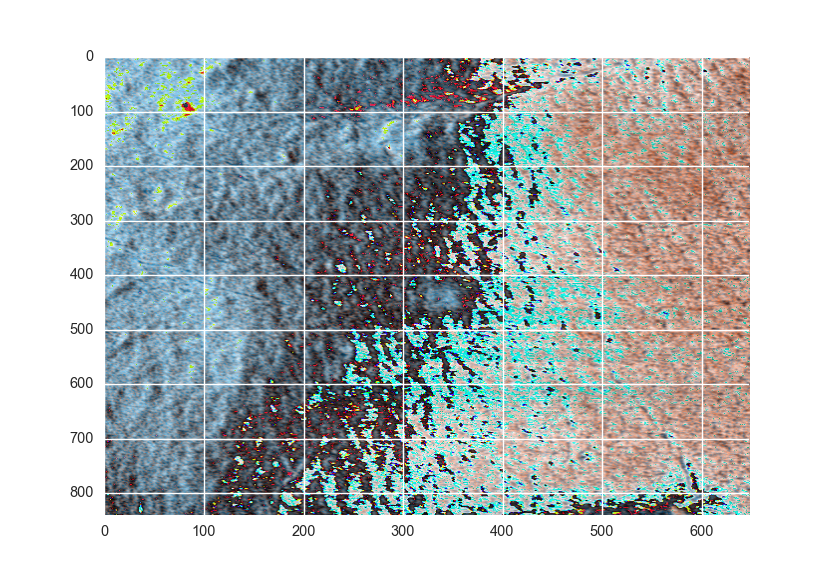

In [80]:
plt.imshow(imgdata.T)

<IPython.core.display.Javascript object>


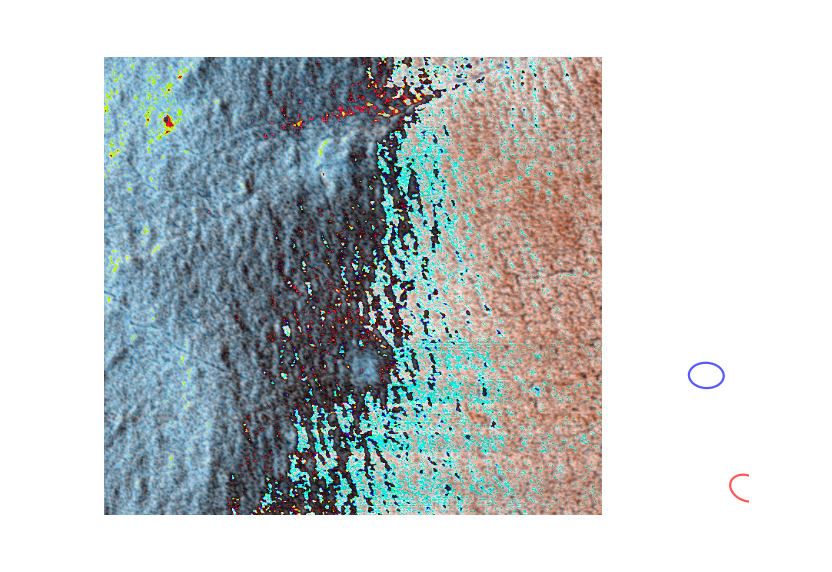

In [105]:
fig, ax = plt.subplots()
ax.imshow(imgdata.T)
p4id.plot_blotches(ax=ax, img=False, blotches=clus_blot)

In [90]:
clustered_blotches = [x.data for x in cm.clustered_blotches]

In [91]:
clustered_fans = [x.data for x in cm.clustered_fans]

In [92]:
clus_blot = pd.concat(clustered_blotches, axis=1).T

In [93]:
clus_fan = pd.concat(clustered_fans, axis=1).T
clus_fan

,x,y,angle,spread,distance
0,108.611104,134.166667,59.424837,17.891215,71.548334
1,204.750000,109.000000,60.406649,18.789800,35.099926
2,146.000000,19.333333,51.036674,34.398692,38.611212
3,86.333333,35.666667,51.723551,21.391094,35.216706
4,169.666667,40.666667,-137.580258,10.434250,33.002564


In [49]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


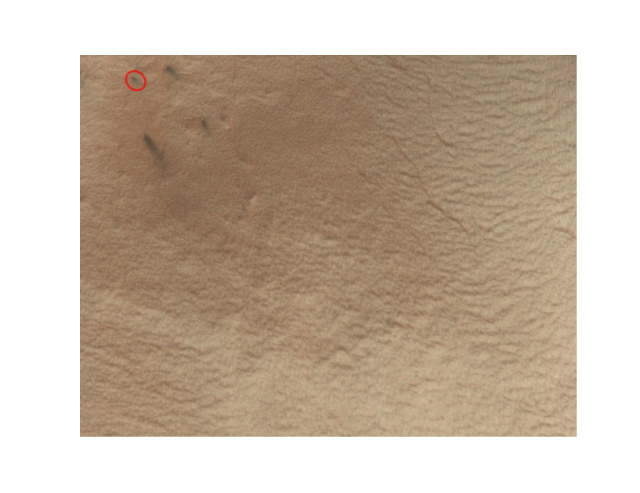

In [94]:
p4id.plot_blotches(blotches=clus_blot)

<IPython.core.display.Javascript object>


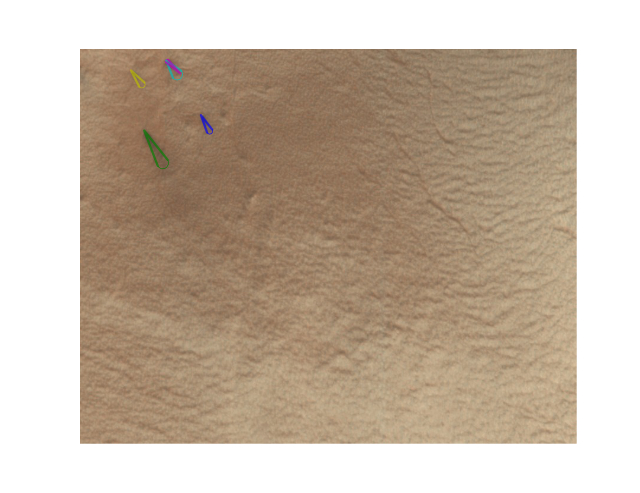

In [95]:
p4id.plot_fans(fans=clus_fan)

In [122]:
fnotch.y.max()/fnotch.x.max()

21.941715713257398

In [129]:
fnotch.fnotch.mean()

-0.65977105283195925

<IPython.core.display.Javascript object>


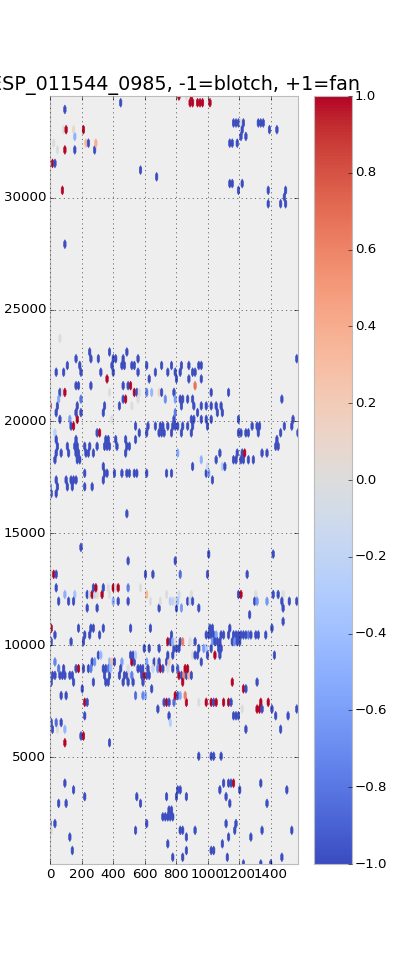

In [134]:
plt.figure(figsize=(5,12))
plt.hexbin(fnotch.x, fnotch.y, C=fnotch.fnotch, cmap='coolwarm')
plt.colorbar()
plt.title('ESP_011544_0985, -1=blotch, +1=fan')

In [135]:
cm.save_confusion_data('/Users/klay6683/Desktop/ESP_011544_0985_confusion_data.csv')

In [103]:
len(cm.clustered_blotches)

645

In [92]:
pd.DataFrame([cm.clustered_blotches[0].data[['hirise_x', 'hirise_y']],
cm.clustered_fans[0].data[['hirise_x', 'hirise_y']]]).mean()

hirise_x       44.50
hirise_y    17850.45
dtype: float64

In [ ]:
cm.

In [19]:
for blotch in cm.clustered_blotches:
    blotch.

In [71]:
def blotchiness(f, b):
    return (f-b)/(f+abs(b))

In [72]:
>>> nx, ny = (5, 5)
>>> x = np.arange(nx)
>>> y = np.arange(ny)
>>> nfans, nblotches = np.meshgrid(x, y)

In [73]:
blotchiness(nfans, nblotches)

array([[        nan,  1.        ,  1.        ,  1.        ,  1.        ],
       [-1.        ,  0.        ,  0.33333333,  0.5       ,  0.6       ],
       [-1.        , -0.33333333,  0.        ,  0.2       ,  0.33333333],
       [-1.        , -0.5       , -0.2       ,  0.        ,  0.14285714],
       [-1.        , -0.6       , -0.33333333, -0.14285714,  0.        ]])

In [74]:
nfans

array([[0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4],
       [0, 1, 2, 3, 4]])

In [70]:
nblotches

array([[0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4]])